# Appendix D Code

## Planck Curves

In [6]:
# https://github.com/NelisW/pyradi.git

import numpy as np
import scipy.optimize
import scipy.constants as const

#np.exp() has upper limit in IEEE double range, catch this 
explimit = 709.7

class PlanckConstants:
    """Precalculate the Planck function constants using the values in
       scipy.constants.  Presumbly these constants are up to date and
       will be kept up to date.

       This module uses the CODATA physical constants. For more details 
       http://physics.nist.gov/cuu/pdf/RevModPhysCODATA2010.pdf
       
        http://docs.scipy.org/doc/scipy/reference/constants.html
    """

    def __init__(self):
        """ Precalculate the Planck function constants.
        http://www.spectralcalc.com/blackbody/appendixC.html
        """

        self.c1em = 2 * np.pi * const.h * const.c * const.c
        # 5 for lambda power and -1 for density
        self.c1el = self.c1em * (1.0e6)**(5-1) 

        self.c1qm = 2 * np.pi * const.c
        # 5 for lambda power and -1 for density
        self.c1ql = self.c1qm * (1.0e6)**(4-1) 

        self.c2m = const.h * const.c / const.k
        self.c2l = self.c2m * 1.0e6 # 1 for wavelength density

        self.sigmae = const.sigma
        self.zeta3 = 1.2020569031595942853
        self.sigmaq = 4 * np.pi * self.zeta3 * const.k ** 3 \
               / (const.h ** 3 * const.c ** 2)

        self.a2 = scipy.optimize.brentq(self.an, 1, 2, (2) )
        self.a3 = scipy.optimize.brentq(self.an, 2, 3, (3) )
        self.a4 = scipy.optimize.brentq(self.an, 3.5, 4, (4) )
        self.a5 = scipy.optimize.brentq(self.an, 4.5, 5, (5) )

        self.wel = 1e6 * const.h * const.c /(const.k * self.a5)
        self.wql = 1e6 * const.h * const.c /(const.k * self.a4)

    def an(self,x,n):
        return n * (1-np.exp(-x)) - x

pconst = PlanckConstants()

In [7]:
def planckel(spectral, temperature):
    """ Planck function in wavelength for radiant exitance.

    Args:
      | spectral (scalar, np.array (N,) or (N,1)): wavelength in  [um]
      | temperature (scalar, list[M], np.array (M,), (M,1) or (1,M)): in [K]

    Returns:
      | (scalar, np.array[N,M]):  spectral radiant exitance in W/(m^2.um)

    Raises:
      | No exception is raised, returns None on error.
    """

    #planckA = pconst.c1el/(spec**5*(np.exp(pconst.c2l/(spec*temp))-1));

    #test value of exponent to prevent infinity, force to exponent to zero
    #this happens for low temperatures and short wavelengths
    exP =  pconst.c2l / (spectral * temperature)
    exP2 = np.where(exP<explimit, exP, 1);
    p = (pconst.c1el / ( np.exp(exP2)-1)) / (spectral ** 5)
    #if exponent is exP>=explimit, force Planck to zero
    planckA = np.where(exP<explimit, p, 0);

    return planckA

In [8]:
def dplnckel(spectral, temperature):
    """Temperature derivative of Planck function in wavelength domain for
    radiant exitance.

    Args:
        | spectral (scalar, np.array (N,) or (N,1)): wavelength in [um]
        | temperature (scalar,list[M],np.array(M,),(M,1) or (1,M)): in [K]

    Returns:
        | (scalar, np.array[N,M]):  spectral radiant exitance in W/(K.m^2.um)

    Raises:
        | No exception is raised, returns None on error.
    """

    # if xx > 350, then we get overflow
    xx = pconst.c2l /(spectral * temperature)
    # refactor (np.exp(xx)-1)**2 to prevent overflow problem
    dplanckA = (pconst.c1el * xx * np.exp(xx) / (np.exp(xx)-1) ) \
        / (temperature* spectral ** 5 * (np.exp(xx)-1) )

    return dplanckA



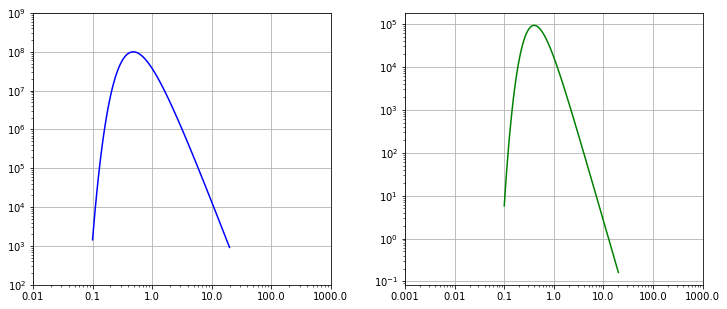

In [32]:
wl = np.logspace(np.log10(0.1),np.log10(20),100)
pel = planckel(wl,6000.)
dpel = dplnckel(wl,6000.)

import pyradi.ryplot as ryplot
p = ryplot.Plotter(1,1,2,figsize=(12,5))
p.logLog(1,wl,pel,pltaxis=[0.1,20,100,1e9],maxNX=5)
p.logLog(2,wl,dpel);

## Filter

In [ ]:
def sfilter(spectral,center, width, exponent=6, taupass=1.0,  \
            taustop=0.0, filtertype = 'bandpass' ):
    """ Calculate a symmetrical filter response of shape exp(-x^n)


    Given a number of parameters, calculates maximally flat,
    symmetrical transmittance.  The function parameters controls
    the width, pass-band and stop-band transmittance and sharpness
    of cutoff. This function is not meant to replace the use of
    properly measured filter responses, but rather serves as a
    starting point if no other information is available.
    This function does not calculate ripple in the pass-band
    or cut-off band.

    Filter types supported include band pass, high (long) pass and
    low (short) pass filters. High pass filters have maximal
    transmittance for all spectral values higher than the central
    value. Low pass filters have maximal transmittance for all
    spectral values lower than the central value.

    Args:
        | spectral (np.array[N,] or [N,1]): spectral vector in  [um] or [cm-1].
        | center (float): central value for filter passband
        | width (float): proportional to width of filter passband
        | exponent (float): even integer, define the sharpness of cutoff.
        |                     If exponent=2        then gaussian
        |                     If exponent=infinity then square
        | taupass (float): the transmittance in the pass band (assumed constant)
        | taustop (float): peak transmittance in the stop band (assumed constant)
        | filtertype (string): filter type, one of 'bandpass', 'lowpass' or 'highpass'

    Returns:
        | transmittance (np.array[N,] or [N,1]):  transmittances at "spectral" intervals.

    Raises:
        | No exception is raised.
        | If an invalid filter type is specified, return None.
        | If negative spectral is specified, return None.
    """

    maxexp = np.log(sys.float_info.max)/np.log(np.max(2*np.abs(spectral-center)/width))
    # minexp = np.log(sys.float_info.min)/np.log(np.min(2*(spectral-center)/width))
    exponent = maxexp if exponent > maxexp else exponent
    # exponent = minexp if exponent < minexp else exponent
    tau = taustop+(taupass-taustop)*np.exp(-(2*np.abs(spectral-center)/width)**exponent)
    maxtau=np.max(tau)
    if filtertype == 'bandpass':
        pass
    elif filtertype == 'lowpass':
        tau = tau * np.greater(spectral,center) + \
                maxtau * np.ones(spectral.shape) * np.less(spectral,center)
    elif filtertype == 'highpass':
        tau = tau * np.less(spectral,center) + \
                maxtau * np.ones(spectral.shape) * np.greater(spectral,center)
    else:
        return None

    return tau

## Responsivity

In [ ]:
def responsivity(wavelength,lwavepeak, cuton=1, cutoff=20, scaling=1.0):
    """ Calculate a photon detector wavelength spectral responsivity

    Given a number of parameters, calculates a shape that is somewhat similar to a photon
    detector spectral response, on wavelength scale. The function parameters controls the
    cutoff wavelength and shape of the response. This function is not meant to replace the use
    of properly measured  spectral responses, but rather serves as a starting point if no other
    information is available.

    Args:
        | wavelength (np.array[N,] or [N,1]):  vector in  [um].
        | lwavepeak (float): approximate wavelength  at peak response
        | cutoff (float): cutoff strength  beyond peak, 5 < cutoff < 50
        | cuton (float): cuton sharpness below peak, 0.5 < cuton < 5
        | scaling (float): scaling factor

    Returns:
        | responsivity (np.array[N,] or [N,1]):  responsivity at wavelength intervals.

    Raises:
        | No exception is raised.
    """

    responsivity=scaling*((wavelength/lwavepeak)**cuton-(wavelength/lwavepeak)**cutoff)
    responsivity= responsivity * (responsivity > 0)

    return responsivity

## Flame Sensor

Optics    : area=0.0078 m^2 FOV=0.0001 [sr]
Amplifier : gain=10000.0 [V/A]
Detector  : peak responsivity=2.5 [A/W]
Flame     : temperature=1273.16 [K] area=1 [m^2] distance=1000 [m]
          : fill=0.009999999999999998 [-]
Flame only: irradiance= 3.29e-04 [W/m^2] signal= 0.0641 [V]
Path      : irradiance= 5.45e-05 [W/m^2] signal= 0.0106 [V]
Flame+Path: irradiance= 3.83e-04 [W/m^2] signal= 0.0746 [V]


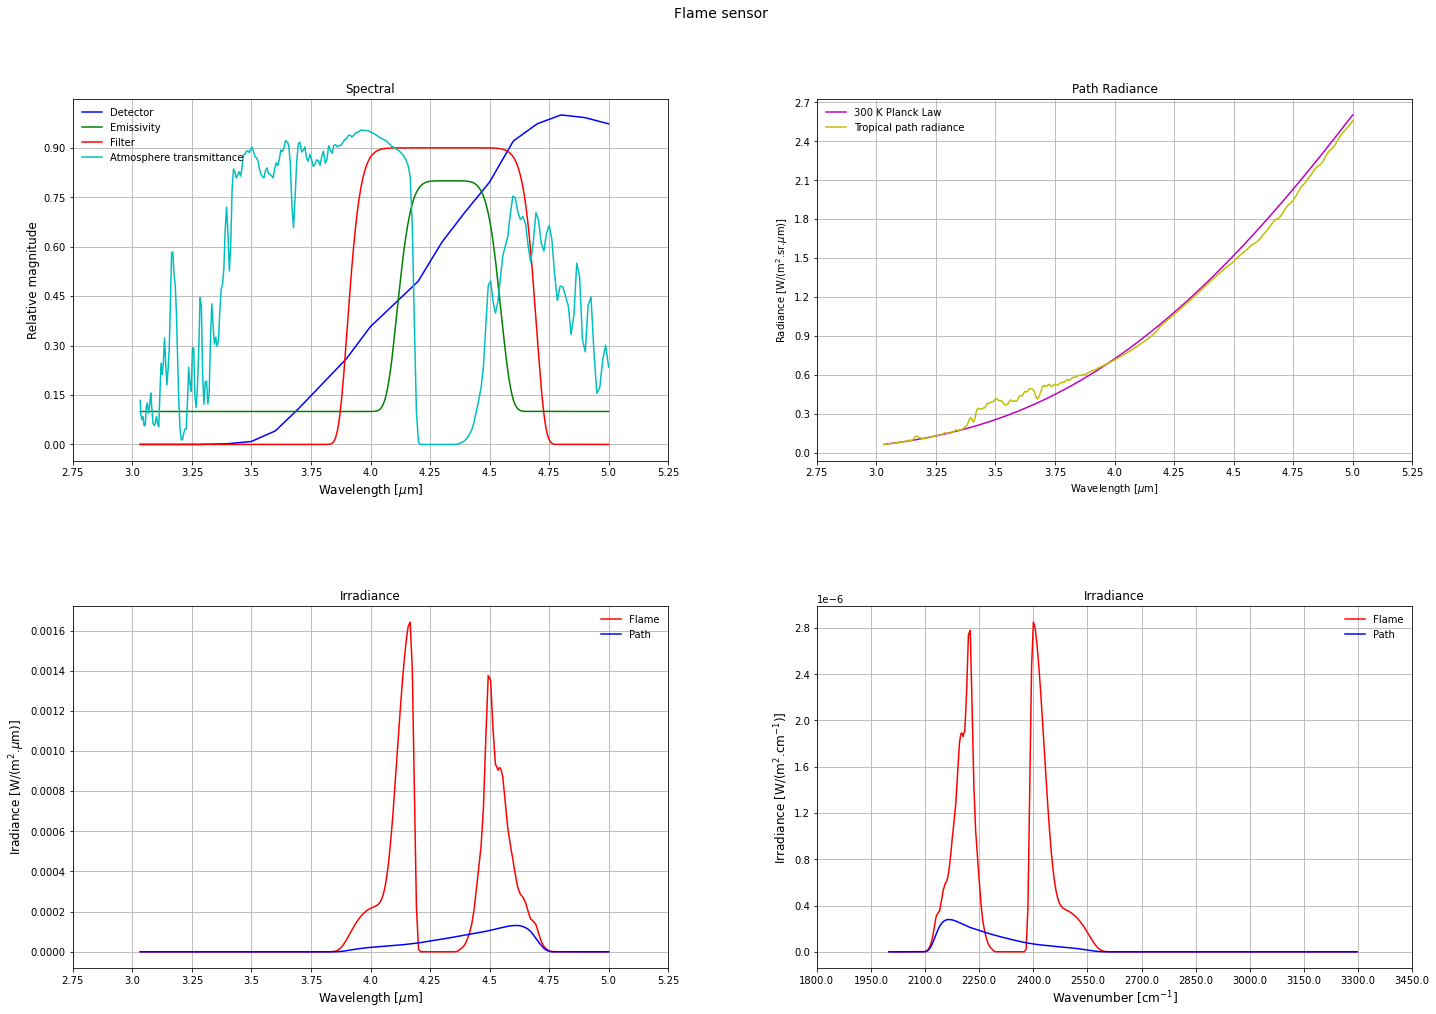

In [5]:
"""
This file provides a simple worked example of a small sensor observing a flame
on a smokestack.

The objective is to calculate the signal of a simple sensor, detecting the
presence or absence of a flame in the sensor field of view. The sensor is
pointed to an area just outside a furnace vent, against a clear sky
background. The sensor must detect a change in signal indicating the presence
of a flame at the vent.

The sensor has an aperture area of 7.8e-3 m^2 and a field of view of 1e-4 sr.
The InSb or PbSe detector has a peak responsivity of 2.5 A/W and spectral
response The preamplifier transimpedance is 10000 V/A.

The flame area is 1 m^2, the flame temperature is 1000 C. The emissivity is
0.1 over most of the spectral band, due to carbon particles in the flame. At
4.3 um there is a strong emissivity rise due to the hot CO2 in the flame.

The distance between the flame and the sensor is 1000~m. We use the  Modtran
Tropical climatic model. The path is oriented such that the sensor stares out to space,
at a zenith angle of 88.8 deg

The peak in the flame emissivity and the dip in atmospheric transmittance are
both centered around the 4.3 um CO2 band. In order to determine the flux
transferred one must perform a spectral calculation taking these strong
spectral variations into account.
"""

#########################################################################
#this example is somewhat contrived, but serves to show toolkit use
# extracted sample code, for full script see https://github.com/NelisW/pyradi.git

import numpy
import pyradi.ryfiles as ryfiles
import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryutils as ryutils

#load atmospheric transmittance created in Modtran in wavenumbers
# the transmittance is specified in the wavenumber domain with
# 5 cm-1 intervals, but we want to work in wavelength with 2.5 cm-1
waven = numpy.arange(2000.0,  3300.0,  2.5).reshape(-1, 1)
wavel= ryutils.convertSpectralDomain(waven,  type='nl')

#scale path radiance from W/cm2.sr.cm-1 to W/m2.sr.cm-1
tauA = ryfiles.loadColumnTextFile('../data/path1kmflamesensor.txt',
    [1],abscissaOut=waven,  comment='%')
lpathwn = ryfiles.loadColumnTextFile('../data/pathspaceflamesensor.txt',
    [9],abscissaOut=waven,  ordinateScale=1.0e4,  comment='%')

#convert path radiance spectral density from 1/cm^-1 to 1/um, 
# the sample wavenumber points
(dum, lpathwl) = ryutils.convertSpectralDensity(waven,  lpathwn, type='nl')
#########################################################################
#load the detector file in wavelengths, and interpolate 
detR = ryfiles.loadColumnTextFile('../data/detectorflamesensor.txt',[1],abscissaOut=wavel,
                                  comment='%')

#construct the flame emissivity from parameters
emis = ryutils.sfilter(wavel,center=4.33,width=0.45,exponent=6,taupass=0.8,taustop=0.1 )

#construct the sensor filter from parameters
sfilter = ryutils.sfilter(wavel,center=4.3,width=0.8,exponent=12,taupass=0.9,taustop=0.0001)
#########################################################################

#plot the data
plot1= ryplot.Plotter(1, 2, 2,'Flame sensor',figsize=(24,16),doWarning=False)

plotdata = detR
plotdata = numpy.hstack((plotdata,emis))
plotdata = numpy.hstack((plotdata,sfilter))
plotdata = numpy.hstack((plotdata,tauA))
label = ['Detector','Emissivity','Filter','Atmosphere transmittance']
plot1.plot(1, wavel, plotdata, "Spectral","Wavelength [$\mu$m]","Relative magnitude",
    label = label, maxNX=10, maxNY=10)
#########################################################################

#check path radiance against Planck's Law for atmo temperature
LbbTropical = ryplanck.planck(wavel, 273+27, type='el').reshape(-1, 1)/numpy.pi
plotdata = LbbTropical
plotdata = numpy.hstack((plotdata,lpathwl))
label=['300 K Planck Law','Tropical path radiance']
plot1.plot(2, wavel, plotdata, label = label)

currentP = plot1.getSubPlot(2)
currentP.set_xlabel('Wavelength [$\mu$m]')
currentP.set_ylabel('Radiance [W/(m$^2$.sr.$\mu$m)]')
currentP.set_title('Path Radiance')

##########################################################
# define sensor scalar parameters
opticsArea=7.8e-3 # optical aperture area [m2]
opticsFOV=1.0e-4 # sensor field of view [sr]
transZ=1.0e4 # amplifier transimpedance gain [V/A]
responsivity=2.5 # detector peak responsivity =A/W]

# define the  flame properties
flameTemperature = 1000+273.16    # temperature in [K]
flameArea = 1  # in [m2]
distance = 1000  # [m]
fill = (flameArea /distance**2) /  opticsFOV # how much of FOV is filled
fill = 1 if fill > 1 else fill # limit target solid angle to sensor FOV
##########################################################


# do case path
inbandirradiancePath =  lpathwn * detR * sfilter * opticsFOV
totalirradiancePath = numpy.trapz(inbandirradiancePath.reshape(-1, 1),waven, axis=0)[0]
signalPath = totalirradiancePath * transZ*responsivity *opticsArea
##########################################################

# do case flame
# get spectral radiance in  W/m^2.sr.cm-1
radianceFlame = ryplanck.planck(waven, flameTemperature,  type='en').reshape(-1, 1)/numpy.pi
inbandirradianceFlame = radianceFlame * detR * tauA * emis * sfilter * fill * opticsFOV
totalirradianceFlame = numpy.trapz(inbandirradianceFlame.reshape(-1, 1),waven, axis=0)[0]
totalirradiancePathremainder = totalirradiancePath * (1-fill)
signalFlameOnly = totalirradianceFlame *transZ*responsivity *opticsArea
signalFlame = (totalirradianceFlame+totalirradiancePathremainder)*transZ*responsivity*opticsArea
##########################################################


print('Optics    : area={0} m^2 FOV={1} [sr]'.format(opticsArea, opticsFOV ))
print('Amplifier : gain={0} [V/A]'.format(transZ))
print('Detector  : peak responsivity={0} [A/W]'.format(responsivity))
print('Flame     : temperature={0} [K] area={1} [m^2] distance={2} [m]'.\
    format(flameTemperature, flameArea, distance))
print('          : fill={0} [-]'.format(fill))
print('Flame only: irradiance={0:9.2e} [W/m^2] signal={1:7.4f} [V]'.\
    format(totalirradianceFlame, signalFlameOnly))
print('Path      : irradiance={0:9.2e} [W/m^2] signal={1:7.4f} [V]'.\
    format(totalirradiancePath, signalPath))
print('Flame+Path: irradiance={0:9.2e} [W/m^2] signal={1:7.4f} [V]'.\
    format(totalirradianceFlame + totalirradiancePathremainder ,signalFlame))
##########################################################

(dum, iFlamewl) = ryutils.convertSpectralDensity(waven,  inbandirradianceFlame, type='nl')
(dum, iPathwl) = ryutils.convertSpectralDensity(waven,  inbandirradiancePath, type='nl')
plot1.plot(3, wavel, iFlamewl, "Irradiance","Wavelength [$\mu$m]",
    "Iradiance [W/(m$^2$.$\mu$m)]",plotCol=['r'], label=['Flame'])
plot1.plot(3, wavel, iPathwl, "Irradiance","Wavelength [$\mu$m]",
    "Iradiance [W/(m$^2$.$\mu$m)]",plotCol=['b'], label=['Path'])
plot1.plot(4, waven, inbandirradianceFlame, "Irradiance","Wavenumber [cm$^{-1}$]",
    "Irradiance [W/(m$^2$.cm$^{-1}$)]",plotCol=['r'], label=['Flame'])
plot1.plot(4, waven, inbandirradiancePath, "Irradiance","Wavenumber [cm$^{-1}$]",
    "Irradiance [W/(m$^2$.cm$^{-1}$)]",plotCol=['b'], label=['Path'], maxNX=10, maxNY=10)

plot1.saveFig('flamesensor01.pdf')



## Object in Image

doing case 0
doing case 1
doing case 2
doing case 3
doing case 4
Maximum contrast is 1.7666616744852506 at 828.6427728546843 m
Range for Koschmieder contrast of 0.02 is 23308.13782342633 m


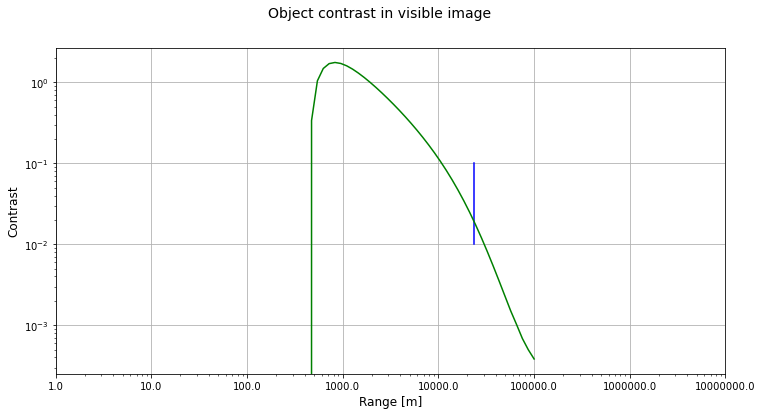

In [50]:
'''
This script calculates the appearance of a target object in an image,
through the atmosphere, against a background.
Three bands are considered: 0.4-0.75 um, 3.5-4.5 um and 8-12 um.
Different target properties are used in each of the three bands.
In all the cases are the sun irradiance part of the signature,
but it only plays a significant role in the visible band.

This code expects the sun transmittance to be pre-calculated, but
the path radiance and transmittance for the path between the source
and receiver are calculated in this code, using Modtran.
For this purpose, this script must be placed in the same directory
as the modtran executable. This code was tested on Windows.

'''
#################################################################
import os,mmap,shutil
import numpy
import pyradi.rymodtran as rymodtran
import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryutils as ryutils
import subprocess
import os.path, fnmatch, time
import contextlib
from scipy.interpolate import    interp1d
#################################################################

# for five cases in three spectral bands
tempTarget = [1500+273, 300, 300, 500, 370]# K
emisTarget = [0.9, 0.9, 0.9, 0.9, 0.9]
tempBackground = [300, 300, 300, 300, 300]    # K
emisBackground = [0.05, 0.0, 1.0, 0.8, 0.9] #
tempSun = 5900    # K
thetaSun = 1.47     # angle between sun and surface normal
omegaPixel = 1e-6 # pixel field of view
areaTarget = 0.2    # area of the target
#################################################################

# 0=vis hot,    1=vis black, 2=vis white, 3=MWIR, 4=LWIR
cases = [0, 1, 2, 3, 4]
calcModtran = False # if true do modtran, otherwise read npz files.

# the following files provide info for different spectral bands.
npfilenames = ['dataVIS.npz', 'dataVIS.npz', 'dataVIS.npz', 'dataMWIR.npz', 'dataLWIR.npz']
tape5filenames = ['tape5.VIS', 'tape5.VIS', 'tape5.VIS', 'tape5.MWIR', 'tape5.LWIR']
archivedirnames = ['archiveVIS', 'archiveVIS', 'archiveVIS', 'archiveMWIR', 'archiveLWIR']
tape7sunfilenames = ['SunVis/tape7.VISSun', 'SunVis/tape7.VISSun', 'SunVis/tape7.VISSun', \
            'SunMWIR/tape7.MWIRSun', 'SunLWIR/tape7.LWIRSun']
caseHeadings = [r'0.4-0.75 $\mu$m (hot target)', \
                r'0.4-0.75 $\mu$m (white background)', \
                r'0.4-0.75 $\mu$m (black background)', \
                r'3.5-4.5 $\mu$m', r'8-12 $\mu$m']
caseAbbrev = [r'VISH', r'VISW', r'VISB', r'MWIR', r'LWIR']
graphScaling = [(1e-7, 1e-3), (1e-7, 1e-4), (1e-7, 1e-4), (1e-8, 1e-4), (1e-7, 1e-4), ]

#################################################################


#set up the distance grid (on log scale)
pathlens = numpy.logspace(2, 5, 50)
#predefine array to use later
# data in columns: Target, Background,Path and Total
Irradiance = numpy.zeros(shape = (len(cases),pathlens.shape[0],4))
ESelect = ['Target','Background','Path','Total',    ]
#################################################################

for case in cases:
    if calcModtran:
        if case == 1 or case == 2: #run once for vis bands
            pass
        else:
            #get the appropriate tape5 file
            shutil.copyfile(tape5filenames[case], 'tape5')
            i = 0 # keep track of first and later passes
#################################################################
            #do for all distances in the list
            for pathlen in pathlens:
                print('Now doing range {0}'.format(pathlen))
                #use memory map to open, change and write the file.
                with open('tape5','r+') as f:
                    with contextlib.closing(mmap.mmap(f.fileno(),0)) as m:
                        strpathlenkm = str(int(pathlen)/1000.).zfill(10)
                        m[306:316] = strpathlenkm
                        m.flush()

                # execute modtran, here in the current working dir
                lstCmd = ['Mod5.2.0.0.exe']
                p=subprocess.Popen(lstCmd)
                while    p.poll() == None:
                    time.sleep(0.5)

                #extract info from tape7
                colSelect =    ['FREQ', 'TOT_TRANS', 'TOTAL_RAD']
                tape7= rymodtran.loadtape7("tape7", colSelect )

                #if visible band, convolve and resample to reduce number of data points
                if case <= 2 :
                    tau7, x = ryutils.convolve(tape7[:,1].reshape(-1,1), 1,    2, 10)
                    lpa7, x = ryutils.convolve(1e4 * tape7[:,2].reshape(-1,1), 1,    2, 10)
                    nu7 = tape7[:,0]
                    tauTab = interp1d(nu7,tau7)
                    lpaTab = interp1d(nu7,lpa7)
                    nu = nu7[0:-1:10].reshape(-1,1)
                    tau = tauTab(nu).reshape(-1,1)
                    lpa = lpaTab(nu).reshape(-1,1)
                else:
                    tau = tape7[:,1].reshape(-1,1)
                    lpa=    1e4 * tape7[:,2].reshape(-1,1)
                    nu = tape7[:,0].reshape(-1,1)

                if i == 0:
                    wavenu = nu
                    transm = tau
                    lpath    = lpa
                else:
                    transm = numpy.hstack((transm,tau))
                    lpath = numpy.hstack((lpath,lpa))

                #copy tape5 & 7 files to new filenames in archive
                tape5filename = 'tape5-'+str(int(pathlen)).zfill(6)
                tape7filename = 'tape7-'+str(int(pathlen)).zfill(6)
                shutil.copyfile('tape5','./'+archivedirnames[case]+'/'+tape5filename)
                shutil.copyfile('tape7','./'+archivedirnames[case]+'/'+tape7filename)
                i = i + 1

            #save summmary data for future reference
            numpy.savez(npfilenames[case], transm=transm, lpath=lpath,
                pathlens=pathlens, wavenu=wavenu )

    else:
        #read from summary data file, don't run modtran
        npzfiles = numpy.load(npfilenames[case])
        transm = npzfiles['transm']
        lpath = npzfiles['lpath']
        wavenu = npzfiles['wavenu']
        pathlens = npzfiles['pathlens']
#################################################################
    #read sun to target transmittance data from tape7 data file
    colSelect =    ['FREQ', 'TOT_TRANS']
    tape7sun = rymodtran.loadtape7(tape7sunfilenames[case], colSelect )
    if case <= 2:
        tauTab = interp1d(tape7sun[:,0],tape7sun[:,1])
        tauSun = tauTab(wavenu).reshape(-1, 1)
    else:
        tauSun = tape7sun[:,1].reshape(-1, 1)
#################################################################
    #spectral radiance [W/(m$^2$.sr.cm$^{-1}$)]
    #target and background has self-radiance as well as reflected sunlight.
    Lsun = ryplanck.planck(wavenu, tempSun, type='en').reshape(-1, 1) / numpy.pi

    LTarg = ryplanck.planck(wavenu, tempTarget[case], type='en').reshape(-1, 1) / numpy.pi
    LTarget = LTarg * emisTarget[case] + \
            numpy.cos(thetaSun) * tauSun * (1 - emisTarget[case])*Lsun*2.177e-5

    LBack = ryplanck.planck(wavenu, tempBackground[case], type='en').reshape(-1, 1) / numpy.pi
    LBackground = LBack * emisBackground[case] + \
            numpy.cos(thetaSun) * tauSun * (1 - emisBackground[case])*Lsun*2.177e-5
#################################################################

    #Now do for all ranges
    for i in numpy.arange(0,pathlens.shape[0]):
        pathlen = pathlens[i]
        #multipy transmittance and integrate over wavelength [W/(m$^2$.sr)]
        LTargetInt=numpy.trapz(LTarget * transm[:,i].reshape(-1,1), wavenu, axis=0)[0]
        LBackgroundInt=numpy.trapz(LBackground * transm[:,i].reshape(-1,1),wavenu, axis=0)[0]
        LPathInt=numpy.trapz(lpath[:,i].reshape(-1,1),wavenu, axis=0)[0]
#################################################################

#         print(pathlen,LTargetInt,LBackgroundInt,LPathInt)
#################################################################

        #target pixel field of view smaller than pixel fov
        omegaTarget = areaTarget / pathlen ** 2
        if omegaTarget > omegaPixel:
            omegaTarget = omegaPixel
        #background fov around target, inside pixel fov
        omegaBackground = omegaPixel - omegaTarget

        #relative contribution to pixel irradiance
        Irradiance[case,i,0] = omegaTarget * LTargetInt
        Irradiance[case,i,1] = omegaBackground * LBackgroundInt
        Irradiance[case,i,2] = omegaPixel * LPathInt
        Irradiance[case,i,3] = Irradiance[case,i,0]+Irradiance[case,i,1]+Irradiance[case,i,2]
#################################################################

    #plot spectral data - huge plot, takes a while
    specplot = ryplot.Plotter(11, 2,1,"Atmospheric spectrals",figsize=(12,6),doWarning=False)
    specplot.plot(1,wavenu,transm,"Transmittance","Wavenumber [cm$^{-1}$]","Transmittance",
               maxNX=10, maxNY=4, powerLimits = [-4,    4, -5, 5])
    specplot.plot(2,    wavenu, lpath, "Path Radiance","Wavenumber [cm$^{-1}$]",\
           "L [W/(m$^2$.sr.cm$^{-1}$)]",maxNX=10, maxNY=4, powerLimits = [-4,    4, -5, 5])
    specplot.saveFig('specplot.pdf')
#################################################################

    #plot irradiance data vs range
    irradplot = ryplot.Plotter(1+case, 1, 1,
        "Object appearance in image: {0}".format(caseHeadings[case]),
            figsize=(12,6),doWarning=False)
    irradplot.logLog(1, pathlens, Irradiance[case,:,:],"","Range [m]",
        "Irradiance [W/m$^2$]", legendAlpha=0.5, label=ESelect,
             pltaxis=[1e2, 1e5, graphScaling[case][0], graphScaling[case][1]],
             maxNX=10, maxNY=4, powerLimits = [-4,    4, -5, 5])
    irradplot.saveFig('rangeplot{0}.pdf'.format(caseAbbrev[case]))
#################################################################

#this is not part of the case loop, do this afterwards
#calc contrast between white and black target (cases 1 & 2)
#investigate atmospheric meteorological range against this result.
contrast =    (Irradiance[1,:,3]-Irradiance[2,:,3])/Irradiance[2,:,3]

#lookup table - contrast initially increasing then decreasing
# use only longer range values.
argmax = numpy.argmax(contrast)
print('Maximum contrast is {0} at {1} m'.format(contrast[argmax],pathlens[argmax]))
contrastTable = interp1d(contrast[-1:argmax:-1], pathlens[-1:argmax:-1],kind = 'linear')
#find the range where contrast is equal to Koschmieder threshold
rangeAtC = contrastTable(0.02)
print('Range for Koschmieder contrast of 0.02 is {0} m'.format(rangeAtC))

contrastplot = ryplot.Plotter(10, 1, 1,
    "Object contrast in visible image", figsize=(12,6),doWarning=False)
contrastplot.logLog(1, numpy.asarray([rangeAtC,rangeAtC]),numpy.asarray([0.01,0.1]),
                    "", "", "",maxNX=10, maxNY=4, powerLimits = [-4,    4, -5, 5])
contrastplot.logLog(1, pathlens,contrast,"","Range [m]","Contrast")
contrastplot.saveFig('contrastplotVis.pdf')



# Colour coordinate calcs


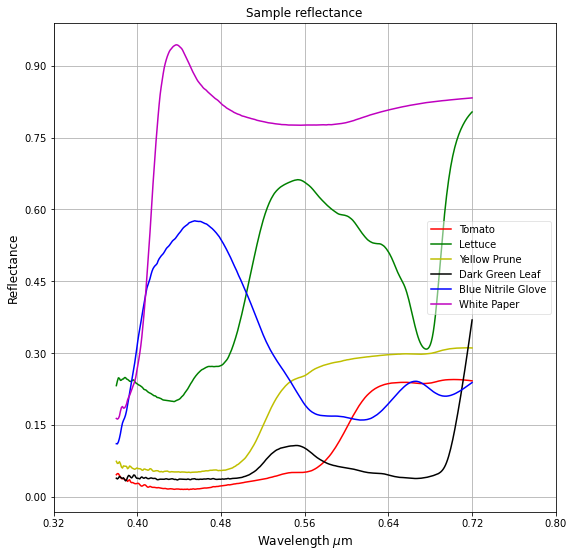

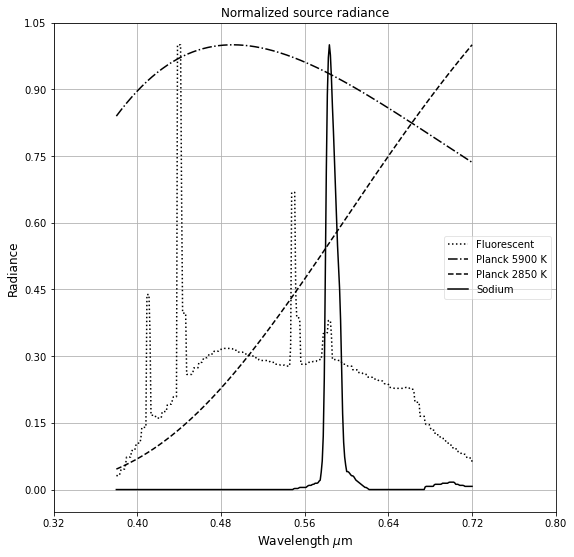

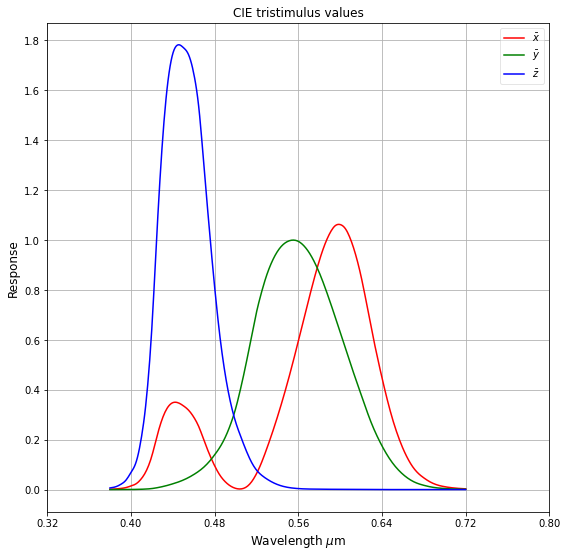

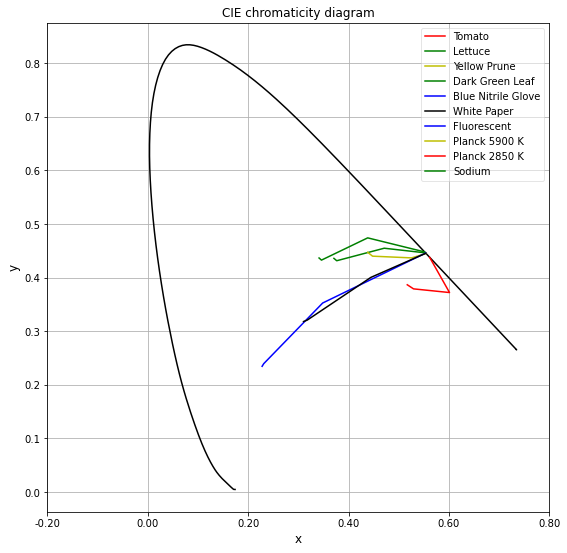

In [56]:
#  $Id$
#  $HeadURL$

################################################################
# The contents of this file are subject to the BSD 3Clause (New) License
# you may not use this file except in
# compliance with the License. You may obtain a copy of the License at
# http://directory.fsf.org/wiki/License:BSD_3Clause

# Software distributed under the License is distributed on an "AS IS"
# basis, WITHOUT WARRANTY OF ANY KIND, either express or implied. See the
# License for the specific language governing rights and limitations
# under the License.

# The Original Code is part of the PyRadi toolkit.

# The Initial Developer of the Original Code is CJ Willers,
# Portions created by CJ Willers are Copyright (C) 2006-2012
# All Rights Reserved.

# Contributor(s): ______________________________________.
################################################################
"""
This module provides rudimentary colour coordinate processing.
Calculate the CIE 1931 rgb chromaticity coordinates for an arbitrary spectrum.

See the __main__ function for examples of use.
"""

import sys
import os
import pkg_resources
from numbers import Number
if sys.version_info[0] > 2:
    from io import StringIO
else:
    from StringIO import StringIO

import numpy as np
from scipy.interpolate import  interp1d

# convert from CIE RGB to XYZ coordinates
mcieRGBtoXYZ = 5.6507 * np.asarray([
    [0.49,0.31,0.20],
    [0.17697,0.81240,0.01063],
    [0.00,0.01,0.99]])

# convert from Adobe RGB to XYZ coordinates
madobeRGBtoXYZ = 3.363153293 * np.asarray([
    [0.57667,0.18556,0.18823],
    [0.29734,0.62736,0.07529],
    [0.02703,0.07069,0.99134]])

# convert from sRGB to CIE xy coordinates - this is only the linear transformation, not gamma
msRGBtoXYZ = 1. * np.asarray([
    [0.4124,0.3576,0.1805],
    [0.2126,0.7152,0.0722],
    [0.0193,0.1192,0.9505]])


# convert from CIE xy to CIE RGB coordinates
mXYZtoCIERGB = np.asarray([
    [0.41847, -0.15866, -0.082835],
    [-0.091169, 0.25243, 0.015708],
    [0.00092090, -0.0025498, 0.17860]])

# convert from CIE xy to Adobe RGB coordinates
mXYZtoAdobeRGB = np.asarray([
    [2.04159, -0.56501, -0.34473],
    [-0.96924, 1.87597, 0.04156],
    [0.01344, -0.11836, 1.01517]])

# convert from CIE xy to sRGB coordinates - this is only the linear transformation, not gamma
mXYZtosRGB = np.asarray([
    [3.2406, -1.5372, -0.4986],
    [-0.9689, 1.8758, 0.0415],
    [0.0557, -0.2040, 1.057]])
################################################################


##############################################################################
##
def chromaticityforSpectralL(spectral,radiance,xbar,ybar,zbar):
    """ Calculate the CIE chromaticity coordinates for an arbitrary spectrum.

    Given a spectral radiance vector and CIE tristimulus curves,
    calculate the CIE chromaticity coordinates. It is assumed that the
    radiance spectral density is given in the same units as the spectral
    vector (i.e. [1/um] or [1/cm-1], corresponding to [um] or [cm-1] respectively.
    It is furthermore accepted that the tristimulus curves are also sampled at
    the same spectral intervals as the radiance. See
    http://en.wikipedia.org/wiki/CIE_1931_color_space
    for more information on CIE tristimulus spectral curves.

    Args:
        | spectral (np.array[N,] or [N,1]): spectral vector in  [um] or [cm-1].
        | radiance (np.array[N,] or [N,1]): the spectral radiance, (sampled at spectral).
        | xbar (np.array[N,] or [N,1]): CIE x tristimulus spectral curve (sampled at spectral).
        | ybar (np.array[N,] or [N,1]): CIE y tristimulus spectral curve (sampled at spectral).
        | zbar (np.array[N,] or [N,1]): CIE z tristimulus spectral curve (sampled at spectral).

    Returns:
        | [x,y,Y]: color coordinates x, y, and Y.

    Raises:
        | No exception is raised.
    """

    X=np.trapz(radiance.reshape(-1, 1)*xbar.reshape(-1, 1),spectral, axis=0)
    Y=np.trapz(radiance.reshape(-1, 1)*ybar.reshape(-1, 1),spectral, axis=0)
    Z=np.trapz(radiance.reshape(-1, 1)*zbar.reshape(-1, 1),spectral, axis=0)

    x=X/(X+Y+Z)
    y=Y/(X+Y+Z)

    return [x[0], y[0], Y[0]]


################################################################
##

if __name__ == '__init__':
    pass

if __name__ == '__main__':

    import math
    import sys
    import pyradi.ryplanck as ryplanck
    import pyradi.ryplot as ryplot
    import pyradi.ryfiles as ryfiles

    figtype = ".png"  # eps, jpg, png

    ## ----------------------- wavelength------------------------------------------
    #create the wavelength scale to be used in all spectral calculations,
    # wavelength is reshaped to a 2-D  (N,1) column vector
    wavelength=np.linspace(0.38, 0.72, 350).reshape(-1, 1)
    wavenum=np.linspace(13333, 27000, 350).reshape(-1, 1)


    ## ----------------------- colour tristimulus ---------------------------------
    # read csv file with wavelength in nm, x, y, z cie tristimulus values (x,y,z).
    # return values are 2-D (N,3) array scaled and interpolated.
    bar = ryfiles.loadColumnTextFile('../data/colourcoordinates/ciexyz31_1.txt', 
                abscissaOut=wavelength,loadCol=[1,2,3],  comment='%', delimiter=',', 
                abscissaScale=1e-3)

################################################################

    ## ------------------------ sources ------------------------------------------
    #build a 2-D array with the source radiance values, where each column
    #represents a different source. Wavelength extends along rows.
    #Spectral interval for all source spectra is the same, which is 'wavelength'
    #Blackbody radiance spectra are calculated at the required wavelength intervals
    #Data read from files are interpolated to the required wavelength intervals
    #Use np.hstack to stack columns horizontally.

    sources = ryfiles.loadColumnTextFile('../data/colourcoordinates/fluorescent.txt',
        abscissaOut=wavelength,comment='%', normalize=1).reshape(-1,1)
    sources = np.hstack((sources, ryplanck.planckel(wavelength,5900).reshape(-1,1)))
    sources = np.hstack((sources, ryplanck.planckel(wavelength,2850).reshape(-1,1)))
    sources = np.hstack((sources, ryfiles.loadColumnTextFile(
                '../data/colourcoordinates/LowPressureSodiumLamp.txt',
                abscissaOut=wavelength, comment='%', normalize=1).reshape(-1,1)))
    #label sources in order of appearance
    sourcesTxt=['Fluorescent', 'Planck 5900 K', 'Planck 2850 K', 'Sodium']

    #normalize the source data (along axis-0, which is along columns)
    #this is not really necessary for CIE xy calc, which normalizes itself.
    #It is however useful for plotting the curves.
    sources /= np.max(sources,axis=0)
################################################################

    ##------------------------- sample data ----------------------------------------
    # read space separated file containing wavelength in um, then sample data.
    # select the samples to be read in and then load all in one call!
    # first line in file contains labels for columns.
    samplesSelect = [1,2,3,8,10,11]
    samples = ryfiles.loadColumnTextFile('../data/colourcoordinates/samples.txt',
         abscissaOut=wavelength, loadCol=samplesSelect,  comment='%')
    samplesTxt=ryfiles.loadHeaderTextFile('../data/colourcoordinates/samples.txt',
                loadCol=samplesSelect, comment='%')

    ##------------------------- plot sample spectra ------------------------------
    smpleplt = ryplot.Plotter(1, 1, 1,doWarning=False)
    smpleplt.plot(1, wavelength, samples, "Sample reflectance", r'Wavelength $\mu$m',
        r'Reflectance', ['r', 'g', 'y','k', 'b', 'm'],label=samplesTxt,legendAlpha=0.5,
        maxNX=5,xAxisFmt='%.2f')
    smpleplt.saveFig('SampleReflectance'+figtype)
################################################################

    ##------------------------- plot source spectra ------------------------------
    srceplt = ryplot.Plotter(2, 1, 1,doWarning=False)
    srceplt.plot(1, wavelength, sources, "Normalized source radiance",r'Wavelength $\mu$m',
        r'Radiance',['k', 'k', 'k', 'k'],linestyle=[':','-.','--','-'],
        label=sourcesTxt,legendAlpha=0.5,maxNX=5,xAxisFmt='%.2f')
    srceplt.saveFig('SourceRadiance'+figtype)

    ##------------------------- plot cie tristimulus spectra ---------------------
    cietriplt = ryplot.Plotter(3, 1, 1,doWarning=False)
    cietriplt.plot(1, wavelength, bar,"CIE tristimulus values",r'Wavelength $\mu$m',
        r'Response', ['r','g','b'], label=['$\\bar{x}$','$\\bar{y}$','$\\bar{z}$'],
        legendAlpha=0.5,maxNX=5,xAxisFmt='%.2f')
    cietriplt.saveFig('tristimulus'+figtype)

################################################################

    ##------------------------- calculate cie xy for samples and sources ---------
    xs = np.zeros((samples.shape[1],sources.shape[1]))
    ys = np.zeros((samples.shape[1],sources.shape[1]))
    for iSmpl in range(samples.shape[1]):
        for iSrc in range(sources.shape[1]):
            [ xs[iSmpl,iSrc], ys[iSmpl,iSrc], Y]=chromaticityforSpectralL(wavelength,
                (samples[:,iSmpl]*sources[:,iSrc]).reshape(-1, 1),bar[:,0], bar[:,1], bar[:,2])
################################################################

    ##---------------------- calculate cie xy for monochromatic  -----------------
    xm=np.zeros(wavelength.shape)
    ym=np.zeros(wavelength.shape)
    #create a series of data points with unity at specific wavelength
    for iWavel in range(wavelength.shape[0]):
        monospectrum=np.zeros(wavelength.shape)
        monospectrum[iWavel] = 1
        #calc xy for single mono wavelength point
        [xm[iWavel],ym[iWavel],Y]=chromaticityforSpectralL(wavelength,
                monospectrum, bar[:,0], bar[:,1], bar[:,2])
################################################################
        #print('{0} um ({1},{2})'.format(wavelength[iWavel],xm[iWavel],ym[iWavel]))

    ##---------------------- plot chromaticity diagram  ---------------------------
################################################################
    ciexyplt = ryplot.Plotter(4, 1, 1,doWarning=False)
    #plot monochromatic horseshoe
    ciexyplt.plot(1, xm, ym,"CIE chromaticity diagram", r'x', r'y', ['k'])
    #plot chromaticity loci for samples
    styleSample=['r', 'g', 'y', 'g', 'b', 'k']
    for iSmpl in range(samples.shape[1]):
        ciexyplt.plot(1,xs[iSmpl],ys[iSmpl],"CIE chromaticity diagram", r'x', r'y',
                [styleSample[iSmpl]], label=[samplesTxt[iSmpl]],legendAlpha=0.5 )
    #plot source markers
    styleSource=['b', 'y', 'r', 'g']
    for iSmpl in range(samples.shape[1]):
        for iSrc in range(sources.shape[1]):
            if iSmpl==0:
                legend=[sourcesTxt[iSrc]]
            else:
                legend=''
            ciexyplt.plot(1,xs[iSmpl,iSrc],ys[iSmpl,iSrc],"CIE chromaticity diagram", r'x',r'y',
                    [styleSource[iSrc]],label=legend,legendAlpha=0.5,maxNX=5,xAxisFmt='%.2f')

    ciexyplt.saveFig('chromaticity'+figtype)


# Range Equation

In [71]:
import numpy
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

def _rangeEquationCalc(r,i,e,tauTable,n,rMax):
    return i * tauTable(r) / (r ** n) - e

def rangeEquation(Intensity, Ethreshold, rangeTab, 
    tauTab, rangeGuess = 1, n = 2):

    #create lookup table
    tauTable = interp1d(rangeTab, tauTab, kind = 'linear')
    #call the scipy solver
    Range = fsolve(_rangeEquationCalc, rangeGuess, 
    args = (Intensity,Ethreshold,tauTable,n,numpy.max(rangeTab),))
    return Range

rangeTab = numpy.linspace(0, 10000, 1000)
tauTab = numpy.exp(- 0.00015 * rangeTab)
Intensity=200
Ethreshold=10e-6
r = rangeEquation(Intensity = Intensity, Ethreshold = Ethreshold,
    rangeTab = rangeTab, tauTab = tauTab, rangeGuess = 1, n = 2)
    
#test the solution by calculating the Ethreshold at this range.
tauTable = interp1d(rangeTab, tauTab, kind = 'linear')
irrad = Intensity * tauTable(r) / r ** 2
error = (irrad[0] - Ethreshold)/Ethreshold
print(f'Range equation solver:')
print(f'Target intensity is {Intensity}, sensor NEE is {Ethreshold:.3e}')
print(f'Range  is {r[0]:.2f} for irradiance threshold is {irrad[0]:.3e}, error is {error:.3e}')


Range equation solver:
Target intensity is 200, sensor NEE is 1.000e-05
Range  is 3452.03 for irradiance threshold is 1.000e-05, error is 1.186e-14


# Pulse Detection

In [75]:
import scipy.special
import numpy
pulsewidth = 100e-9
FAR = 15
probDetection = 0.999
ThresholdToNoise = numpy.sqrt(-2 * numpy.log (2 * pulsewidth 
     * numpy.sqrt(3) * FAR ))
SignalToNoise = numpy.sqrt(2) * scipy.special.erfinv(2 * 
   probDetection -1 ) + ThresholdToNoise
print(f'For a laser pulse with width={pulsewidth}, a FAR={FAR} and Pd={probDetection},')
print(f'the Threshold to Noise ratio must be {ThresholdToNoise:.3f}')
print(f'and the Signal to Noise ratio must be {SignalToNoise:.3f}')


For a laser pulse with width=1e-07, a FAR=15 and Pd=0.999,
the Threshold to Noise ratio must be 4.933
and the Signal to Noise ratio must be 8.023


# Solid Angle

In [77]:
import numpy as np
x,y = np.mgrid[-45:45:181j, -52:52:209j]
gv = (1 / ( (x/60)**2 + (y/60)**2 +1 ) ) **(3./2)
a = np.trapz(gv, dx=0.5)
solidAngle = np.trapz(a, dx=0.5)/(60*60)
print(f'Solid angle {solidAngle:.3f} sr')

Solid angle 1.615 sr
